In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure
myseed = 2020815  # 建立随机数种子
torch.backends.cudnn.deterministic = True  # 每次返回的卷积算法将是确定的
torch.backends.cudnn.benchmark = False  # 加速卷积实现算法
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [2]:
def get_device():
    ''' 显示GPU是否可用'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' 画出本项目中loss随着训练的变化'''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' 画出本项目中预测函数的变化 '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('covid.train.csv')
x = data[data.columns[1:94]]
y = data[data.columns[94]]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn import preprocessing
x = (x - x.min()) / (x.max() - x.min())  # 归一化

bestfeatures = SelectKBest(score_func=f_regression, k=5)  # 设定特征搜索的算法
fit = bestfeatures.fit(x,y)  # 代入数据搜寻特征
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#将两个表融合起来
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [4]:
class COVID19Dataset(Dataset):
    ''' 创建一个COVID19Dataset类，继承Dataset类 '''
    def __init__(self, path, mode='train', target_only=True):
        self.mode = mode

        # 根据文件路径读取数据,将数据转化为np.array数据
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
         
        if not target_only:
            """如果不选择SelectKBest算法中选择出来的特征"""
            feats = list(range(93))
        else:
            """如果只选择SelectKBest算法中选择出来的特征"""
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77] #上面挑选的最优特征
        if mode == 'test':
            # 测试数据的情况下没有target，因此只需要输入特征列data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # 如果是验证集或者训练集的情况下，输入数据既有特征列又有标签列
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # 在确定参数后，使用所有数据进行训练，即训练集和验证集
            if mode == 'train':
                #indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                #indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
        

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [6]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),#使用BN，加速模型训练
            nn.Dropout(p=0.2),#使用Dropout，减小过拟合，注意不能在BN之前
            nn.LeakyReLU(),#更换激活函数
            nn.Linear(32, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        #self.criterion = nn.SmoothL1Loss(size_average=True)

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        regularization_loss = 0
        for param in model.parameters():
        # TODO: you may implement L1/L2 regularization here
        # 使用L2正则项
            # regularization_loss += torch.sum(abs(param))
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss

In [7]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [8]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [9]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [10]:
device = get_device()
os.makedirs('models', exist_ok=True) 
target_only = True                   # 使用前面设置的特征

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 500,                # 因为有early_stop，所以大一点没有影响
    'batch_size': 200,               # 微调batchsize
    'optimizer': 'Adam',              # 使用Adam优化器
    'optim_hparas': {                # 完全使用默认参数
        #'lr': 0.0001,                 
        #'momentum': 0.9,             
        #'weight_decay': 5e-4,
    },
    'early_stop': 500,               # 由于最后训练使用了所有数据，大一点影响不大
    'save_path': 'models/model.pth'  
}

In [11]:
tr_set = prep_dataloader("covid.train.csv", 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader("covid.train.csv", 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader("covid.test.csv", 'test', config['batch_size'], target_only=target_only)
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [12]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 290.9602)
Saving model (epoch =    2, loss = 245.7988)
Saving model (epoch =    6, loss = 242.0112)
Saving model (epoch =    7, loss = 229.7668)
Saving model (epoch =    8, loss = 224.1967)
Saving model (epoch =    9, loss = 217.0347)
Saving model (epoch =   10, loss = 204.2584)
Saving model (epoch =   11, loss = 192.1418)
Saving model (epoch =   12, loss = 186.4047)
Saving model (epoch =   13, loss = 174.9766)
Saving model (epoch =   14, loss = 150.2182)
Saving model (epoch =   15, loss = 133.6947)
Saving model (epoch =   16, loss = 115.8392)
Saving model (epoch =   20, loss = 107.4278)
Saving model (epoch =   21, loss = 106.5253)
Saving model (epoch =   22, loss = 95.3793)
Saving model (epoch =   23, loss = 80.4677)
Saving model (epoch =   24, loss = 69.2772)
Saving model (epoch =   25, loss = 60.0892)
Saving model (epoch =   27, loss = 59.5370)
Saving model (epoch =   28, loss = 46.7289)
Saving model (epoch =   31, loss = 46.6720)
Saving model (epo

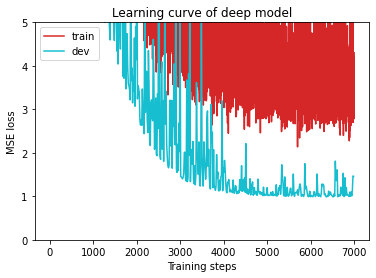

In [13]:
plot_learning_curve(model_loss_record, title='deep model')